In [1]:
import numpy as np
import numba
import scipy.sparse as ssp
import scipy.stats
import time
import sys
import pdb
from functools import partial
# %load_ext line_profiler
%load_ext autoreload
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

In [2]:
from QH_ED import landau
from QH_ED import utils
from QH_ED import hilbert
from QH_ED import observables
from functools import partial

## A simple calculation of 8 electrons at $\nu=1/3$ in the LLL 

In [3]:
Nphi = 24
Ne = 8
sector = 4
Nth = 4

torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
hamParams = {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index
vParams1 = {'power': (1.0, {'n': 1, 'x': np.inf})} # Coulomb power law, Gaussian cut-off
vParams2 = {'haldane': (1.0, {'Vm': [0, 1]})} # Haldane pseudopotential

pot1 = landau.Potential(torus=torus1, vParams=vParams1, hamParams=hamParams)
pot1.setV2()
T41 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

pot2 = landau.Potential(torus=torus1, vParams=vParams2, hamParams=hamParams)
pot2.setV2()
T42 = np.real(utils.Utils.make4tensorsym(torus1, pot2.V2))

hilb_s, hilbLen_s = utils.Utils.getHilb(Nphi, Ne, sector)
dictx = hilbert.getDict(hilb_s)
NH = len(hilb_s)

dij1 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T41, dictx, Nth)
dij2 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T42, dictx, Nth)

HMat1 = hilbert.dijToCsr(dij1, NH)
HMat2 = hilbert.dijToCsr(dij2, NH)

In [4]:
E1, V1 = ssp.linalg.eigsh(HMat1, k=6, which='SA')
E2, V2 = ssp.linalg.eigsh(HMat2, k=6, which='SA')

In [5]:
E1, E2

(array([-2.02014901, -1.95465458, -1.95465458, -1.93826526, -1.93780827,
        -1.93780827]),
 array([-2.33333333, -1.91113698, -1.91113698, -1.90871525, -1.71754719,
        -1.71754719]))

## ground state

In [6]:
print("Coulomb: {0:.6f}".format(E1[0]/Ne))
print("Laughlin: {0:.6f}".format(E2[0]/Ne))

Coulomb: -0.252519
Laughlin: -0.291667


In [7]:
print("Wavefunction overlap: {0:.6f}".format(np.dot(V1[:, 0], V2[:, 0])**2))

Wavefunction overlap: 0.980256


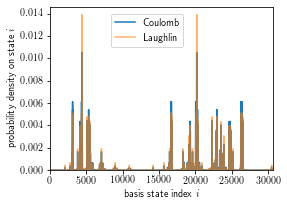

In [8]:
f, ax = plt.subplots(1, 1, figsize=(4,3))
ax.plot(V1[:, 0]**2, label='Coulomb')
ax.plot(V2[:, 0]**2, alpha=0.6, label='Laughlin')
ax.set_xlabel(r'basis state index $i$')
ax.set_ylabel(r'probability density on state $i$')
ax.set_xlim([0, sum(hilbLen_s)])
ax.set_ylim(0)
ax.legend(loc='upper left', bbox_to_anchor=(0.25, 0.99))

In [9]:
hilbObj1 = hilbert.Hilbert(Nphi=Nphi, Ne=Ne, NH=NH, hilb=hilb_s, hilbLen=hilbLen_s, dictx=dictx)
obs1 = observables.Observables(torus1, hamParams, hilbObj1)

In [10]:
nX = 30
x_diag = 0.5 * np.arange(nX+1) * torus1.Lx / nX
r_arr = np.c_[x_diag, x_diag]
gRdiag1 = obs1.gr(r_arr, V1[:, 0])
gRdiag2 = obs1.gr(r_arr, V2[:, 0])

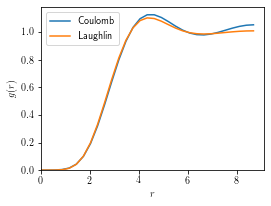

In [11]:
f, ax = plt.subplots(figsize=(4,3))
ax.plot(x_diag*np.sqrt(2), gRdiag1, label='Coulomb')
ax.plot(x_diag*np.sqrt(2), gRdiag2, label='Laughlin')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$g(r)$')
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(loc='best')

## playing around with Gaussian interactions 

In [49]:
s_arr = np.r_[0.1, 0.5, 1.0, 2.0, 3.0, 10.0]
E1_arr = np.zeros((len(s_arr), 6))
V1_arr = np.zeros((len(s_arr), sum(hilbLen_s), 6))
ov_arr = np.zeros((len(s_arr), 6))

hamParams = {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index

for cs, s in enumerate(s_arr):
    vParams1 = {'power': (1.0, {'n': 0, 'x': s})}
    pot1 = landau.Potential(torus=torus1, vParams=vParams1, hamParams=hamParams)
    pot1.setV2()
    T41 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))
    dij1 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T41, dictx, Nth)
    HMat1 = hilbert.dijToCsr(dij1, NH)
    Ex, Vx = ssp.linalg.eigsh(HMat1, k=6, which='SA')
    E1_arr[cs, :] = Ex
    V1_arr[cs, :, :] = Vx
    ov_arr[cs, :] = np.dot(Vx.T, V2[:, 0])**2

Text(0.5, 0, '$\\delta V_1$')

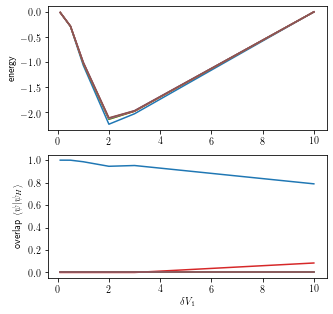

In [50]:
f, ax = plt.subplots(2, 1, figsize=(5, 5))
for i in np.arange(6):
    ax[0].plot(s_arr, E1_arr[:, i])
    ax[1].plot(s_arr, ov_arr[:, i])
# ax[0].set_xlim([s_arr[0], s_arr[-1]])
# ax[1].set_xlim([s_arr[0], s_arr[-1]])
ax[0].set_ylabel(r'energy')
ax[1].set_ylabel(r'overlap $\langle \psi | \psi_H \rangle$')
ax[1].set_xlabel(r'$s$')

## EXPERIMENTS in $n=1$ LL

In [12]:
Nphi = 24
Ne = 8
sector = 4
Nth = 4

torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
hamParams = {'alpha': 1.0, 'n': 1, 'Nphi': Nphi} # mass anisotropy, Landau level index
vParams1 = {'power': (1.0, {'n': 1, 'x': np.inf})} # Coulomb power law, Gaussian cut-off
vParams2 = {'haldane': (1.0, {'Vm': [0, 1]})} # Haldane pseudopotential

pot1 = landau.Potential(torus=torus1, vParams=vParams1, hamParams=hamParams)
pot1.setV2()
T41 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

pot2 = landau.Potential(torus=torus1, vParams=vParams2, hamParams=hamParams)
pot2.setV2()
T42 = np.real(utils.Utils.make4tensorsym(torus1, pot2.V2))

hilb_s, hilbLen_s = utils.Utils.getHilb(Nphi, Ne, sector)
dictx = hilbert.getDict(hilb_s)
NH = len(hilb_s)

dij1 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T41, dictx, Nth)
dij2 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T42, dictx, Nth)

HMat1 = hilbert.dijToCsr(dij1, NH)
HMat2 = hilbert.dijToCsr(dij2, NH) 

E1, V1 = ssp.linalg.eigsh(HMat1, k=6, which='SA')
E2, V2 = ssp.linalg.eigsh(HMat2, k=6, which='SA')

In [13]:
print("Coulomb: {0:.6f}".format(E1[0]/Ne))
print("Laughlin: {0:.6f}".format(E2[0]/Ne))

Coulomb: -0.174887
Laughlin: 0.586379


In [14]:
print("Wavefunction overlap: {0:.6f}".format(np.dot(V1[:, 0], V2[:, 0])**2))

Wavefunction overlap: 0.000000


In [13]:
hilbObj1 = hilbert.Hilbert(Nphi=Nphi, Ne=Ne, NH=NH, hilb=hilb_s, hilbLen=hilbLen_s, dictx=dictx)
obs1 = observables.Observables(torus1, hamParams, hilbObj1)

In [14]:
nX = 60
x_diag = 0.5 * np.arange(nX+1) * torus1.Lx / nX
r_arr = np.c_[x_diag, x_diag]
gRdiag1 = obs1.gr(r_arr, V1[:, 0])
gRdiag2 = obs1.gr(r_arr, V2[:, 0])

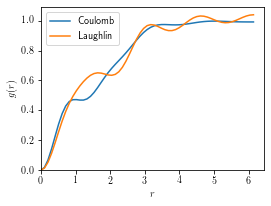

In [15]:
f, ax = plt.subplots(figsize=(4,3))
ax.plot(x_diag*np.sqrt(2), gRdiag1, label='Coulomb')
ax.plot(x_diag*np.sqrt(2), gRdiag2, label='Laughlin')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$g(r)$')
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(loc='best')

## Gaussian interactions in the $n=1$ LL

In [16]:
s_arr = np.r_[0.1:0.501:0.1, 0.55, 0.6:0.701:0.01, 0.8, 0.9]
E1_arr = np.zeros((len(s_arr), 6))
V1_arr = np.zeros((len(s_arr), sum(hilbLen_s), 6))
ov1_arr = np.zeros((len(s_arr), 6))
ov2_arr = np.zeros((len(s_arr), 6))

hamParams = {'alpha': 1.0, 'n': 1, 'Nphi': Nphi} # mass anisotropy, Landau level index

for cs, s in enumerate(s_arr):
    vParams1 = {'power': (1.0, {'n': 0, 'x': s})}
    pot1 = landau.Potential(torus=torus1, vParams=vParams1, hamParams=hamParams)
    pot1.setV2()
    T41 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))
    dij1 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T41, dictx, Nth)
    HMat1 = hilbert.dijToCsr(dij1, NH)
    Ex, Vx = ssp.linalg.eigsh(HMat1, k=6, which='SA')
    E1_arr[cs, :] = Ex
    V1_arr[cs, :, :] = Vx
    ov1_arr[cs, :] = np.dot(Vx.T, V1[:, 0])**2
    ov2_arr[cs, :] = np.dot(Vx.T, V2[:, 0])**2

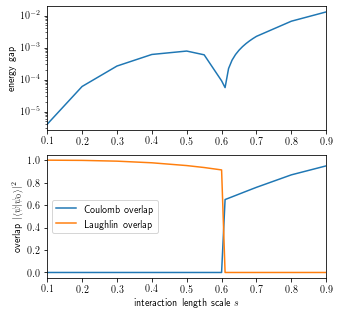

In [17]:
f, ax = plt.subplots(2, 1, figsize=(5, 5))
for i in np.arange(1):
    ax[0].plot(s_arr, E1_arr[:, i+1] - E1_arr[:, i])
    ax[1].plot(s_arr, ov1_arr[:, i], label='Coulomb overlap')
    ax[1].plot(s_arr, ov2_arr[:, i], label='Laughlin overlap')
ax[0].set_xlim([s_arr[0], s_arr[-1]])
ax[1].set_xlim([s_arr[0], s_arr[-1]])
ax[0].set_ylabel(r'energy gap')
ax[1].set_ylabel(r'overlap $| \langle \psi | \psi_0 \rangle |^2$')
ax[1].set_xlabel(r'interaction length scale $s$')
ax[1].legend(loc='best')

ax[0].set_yscale('log')
# f.savefig('/home/ak20/QH/plots/gaussian_n1.pdf')

In [16]:
aH_arr = np.r_[0, 0.03, 0.04, 0.05, 0.06, 0.1]
E1_arr = np.zeros((len(aH_arr), 6))
V1_arr = np.zeros((len(aH_arr), sum(hilbLen_s), 6))
ov_arr = np.zeros((len(aH_arr), 6))

for caH, aH in enumerate(aH_arr):
    vParams1 = {'power': (1.0, {'n': 1, 'x': np.inf}),
                'haldane': (aH, {'Vm': [0, 1]})}
    pot1 = landau.Potential(torus=torus1, vParams=vParams1, hamParams=hamParams)
    pot1.setV2()
    T41 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))
    dij1 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T41, dictx, Nth)
    HMat1 = hilbert.dijToCsr(dij1, NH)
    Ex, Vx = ssp.linalg.eigsh(HMat1, k=6, which='SA')
    E1_arr[caH, :] = Ex
    V1_arr[caH, :, :] = Vx
    ov_arr[caH, :] = np.dot(Vx.T, V2[:, 0])**2

Text(0.5, 0, '$\\delta V_1$')

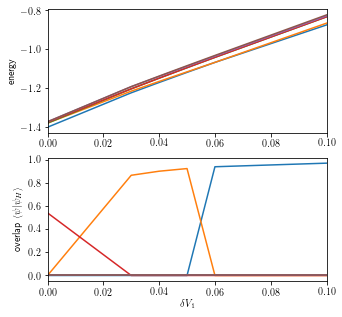

In [19]:
f, ax = plt.subplots(2, 1, figsize=(5, 5))
for i in np.arange(6):
    ax[0].plot(aH_arr, E1_arr[:, i])
    ax[1].plot(aH_arr, ov_arr[:, i])
ax[0].set_xlim([aH_arr[0], aH_arr[-1]])
ax[1].set_xlim([aH_arr[0], aH_arr[-1]])
ax[0].set_ylabel(r'energy')
ax[1].set_ylabel(r'overlap $\langle \psi | \psi_H \rangle$')
ax[1].set_xlabel(r'$\delta V_1$')

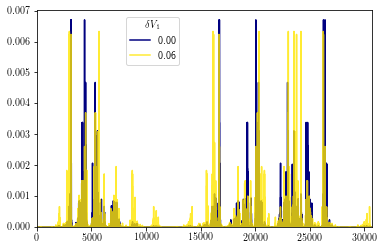

In [82]:
f, ax = plt.subplots(1, 1)
for caH, aH in enumerate(aH_arr):
    if aH in [0, 0.06]:
        ax.plot(V1_arr[caH, :]**2, color=plt.cm.jet(caH/len(aH_arr)),
            alpha=1-0.05*caH, label='{0:.2f}'.format(aH))
ax.set_xlim([0, sum(hilbLen_s)])
ax.set_ylim(0)
ax.legend(loc='upper left', bbox_to_anchor=(0.25, 0.99), title='$\delta V_1$')

In [ ]:
s_arr = np.r_[0.1, 0.5, 1.0, 2.0, 3.0, 10.0]
E1_arr = np.zeros((len(s_arr), 6))
V1_arr = np.zeros((len(s_arr), sum(hilbLen_s), 6))
ov_arr = np.zeros((len(s_arr), 6))

hamParams = {'alpha': 1.0, 'n': 1, 'Nphi': Nphi} # mass anisotropy, Landau level index

for cs, s in enumerate(s_arr):
    vParams1 = {'power': (1.0, {'n': 0, 'x': s})}
    pot1 = landau.Potential(torus=torus1, vParams=vParams1, hamParams=hamParams)
    pot1.setV2()
    T41 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))
    dij1 = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T41, dictx, Nth)
    HMat1 = hilbert.dijToCsr(dij1, NH)
    Ex, Vx = ssp.linalg.eigsh(HMat1, k=6, which='SA')
    E1_arr[cs, :] = Ex
    V1_arr[cs, :, :] = Vx
    ov_arr[cs, :] = np.dot(Vx.T, V2[:, 0])**2

## other experiments

In [35]:
Nphi = 24
Ne = 8
sector = 4
Nth = 4

torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
hamParams = {'alpha': 1.0, 'n': 1, 'Nphi': Nphi} # mass anisotropy, Landau level index
vParams2 = {'power': (1.0, {'n': 1, 'x': np.inf}), 
            'haldane': (0.06, {'Vm': [0, 1]})} # Haldane pseudopotential

pot2 = landau.Potential(torus=torus1, vParams=vParams2, hamParams=hamParams)
pot2.setV2()
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot2.V2))

hilb = [None]*Ne
hilbLen = [None]*Ne
dictx = [None]*Ne

for sector in range(Ne):
    hilb[sector], hilbLen[sector] = utils.Utils.getHilb(Nphi, Ne, sector)
    dictx[sector] = hilbert.getDict(hilb[sector])
    
E_all = [None]*Ne
V_all = [None]*Ne
    
for sector in range(Ne):
    NH = len(hilb[sector])
    dij = hilbert.getMatAux(Nphi, Ne, NH, hilb[sector], hilbLen[sector], T4, dictx[sector], Nth)
    HMat = hilbert.dijToCsr(dij, NH)
    E_all[sector], V_all[sector] = scipy.sparse.linalg.eigsh(HMat, k=16, which='SA')

In [28]:
E_all

[array([-1.06135108, -1.03562816, -1.031939  , -1.031939  , -1.03001798,
        -1.03001798, -1.0272241 , -1.0272241 , -1.02714516, -1.02075938,
        -1.00237354, -1.00237354, -0.99800678, -0.99609205, -0.99609205,
        -0.99362559]),
 array([-1.04837756, -1.04837756, -1.03741783, -1.03741783, -1.0320879 ,
        -1.03001798, -1.01720797, -1.01720797, -1.01341052, -1.01341052,
        -1.01102112, -1.01102112, -1.00872786, -1.00237354, -0.99373338,
        -0.99373338]),
 array([-1.05107838, -1.05107838, -1.04190971, -1.03741783, -1.03741783,
        -1.03217606, -1.03217606, -1.0272241 , -1.02400301, -1.01341052,
        -1.01341052, -1.01073165, -1.01073165, -1.00975404, -1.00975404,
        -0.99609205]),
 array([-1.04837756, -1.04837756, -1.03217606, -1.03217606, -1.031939  ,
        -1.02405765, -1.02405765, -1.00975404, -1.00975404, -1.00907011,
        -1.00718729, -1.00195506, -1.00195506, -0.99373338, -0.99373338,
        -0.99017925]),
 array([-1.0676262 , -1.06752381

In [34]:
np.dot(V_all[4][:, 0], V2[:, 0])**2

1.2819578407083784e-23